In [1]:
import cv2
import os
import glob

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

CALIBRATION_DIR = 'camera_cal'
TEST_DIR = 'test_images'
UNDISTORTED_DIR = 'undistorted_images'
if not os.path.isdir(UNDISTORTED_DIR):
    os.mkdir(UNDISTORTED_DIR)

In [2]:
def plot_side_by_side(image,
                      comparison):
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=40)

    ax2.imshow(comparison)
    ax2.set_title('Comparison Image', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

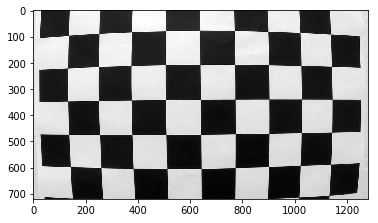

In [3]:
TEST_IMAGE = os.path.join(CALIBRATION_DIR,
                          'calibration1.jpg')
img = cv2.imread(TEST_IMAGE)
gray = cv2.cvtColor(img,
                    cv2.COLOR_BGR2GRAY)

plt.imshow(gray,
           cmap='gray')

In [4]:
def find_corners(file_name,
                 nx,
                 ny):
    # termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    refined_corners = None
    
    img = cv2.imread(file_name)
    grey = cv2.cvtColor(img,
                        cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(grey,
                                             (nx,ny),
                                             None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        print("Corners found")
        refined_corners = cv2.cornerSubPix(grey,
                                           corners,
                                           (11,11),
                                           (-1,-1),
                                           criteria)
        
#         # Draw and display the corners
#         img = cv2.drawChessboardCorners(img, (7,6), refined_corners,ret)
#         plt.imshow(img)
#         cv2.waitKey(500)

    # If you don't find any corners, try again with fewer rows
    if ret == False and nx == 6:
        print("Trying again with fewer rows")
        objp, refined_corners = find_corners(file_name,
                                             nx-1,
                                             ny)
    # If you don't find any corners, try again with fewer columns
    if ret == False and nx == 5:
        print("Trying again with fewer columns")
        objp, refined_corners = find_corners(file_name,
                                             nx,
                                             ny-1)
        
    return objp, refined_corners

In [5]:
NX = 6
NY = 9

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

calibration_image_path = os.path.join(CALIBRATION_DIR,
                               '*.jpg')
# test_image_path = os.path.join(CALIBRATION_DIR,
#                                'calibration1.jpg')
images = glob.glob(calibration_image_path)

for file_name in images:
    print("Processing {}".format(file_name))
    objp, imgp = find_corners(file_name,
                              NX,
                              NY)
    
    objpoints.append(objp)
    imgpoints.append(imgp)

Processing camera_cal\calibration1.jpg
Trying again with fewer rows
Corners found
Processing camera_cal\calibration10.jpg
Corners found
Processing camera_cal\calibration11.jpg
Corners found
Processing camera_cal\calibration12.jpg
Corners found
Processing camera_cal\calibration13.jpg
Corners found
Processing camera_cal\calibration14.jpg
Corners found
Processing camera_cal\calibration15.jpg
Corners found
Processing camera_cal\calibration16.jpg
Corners found
Processing camera_cal\calibration17.jpg
Corners found
Processing camera_cal\calibration18.jpg
Corners found
Processing camera_cal\calibration19.jpg
Corners found
Processing camera_cal\calibration2.jpg
Corners found
Processing camera_cal\calibration20.jpg
Corners found
Processing camera_cal\calibration3.jpg
Corners found
Processing camera_cal\calibration4.jpg
Trying again with fewer rows
Trying again with fewer columns
Trying again with fewer columns
Trying again with fewer columns
Corners found
Processing camera_cal\calibration5.jpg
T

In [6]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

In [7]:
def undistort_image(file_name,
                    save_directory,
                    image,
                    objpoints,
                    imgpoints,
                    matrix,
                    dist,
                    rvecs,
                    tvecs):
    height, width = image.shape[:2]
    
    # Refine camera matrix
    new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(matrix,
                                                           dist,
                                                           (width, height),
                                                           1,
                                                           (width,height))
    
    # Undistort
    undistorted = cv2.undistort(image,
                                matrix,
                                dist,
                                None,
                                new_camera_matrix)

    # crop the image
    x, y, new_width, new_height = roi
    undistorted = undistorted[y:y+new_height, x:x+new_width]
    
    # Save image
    undistorted_file_name = os.path.join(save_directory,
                                         file_name.split('\\')[-1])
    print(undistorted_file_name)
    cv2.imwrite(undistorted_file_name,
                undistorted)

    total_error = 0
    for i in range(len(objpoints)):
        imgpoints2, _ = cv2.projectPoints(objpoints[i],
                                          rvecs[i],
                                          tvecs[i], 
                                          matrix,
                                          dist)
        error = cv2.norm(imgpoints[i],
                         imgpoints2,
                         cv2.NORM_L2) / len(imgpoints2)
        total_error += error

    mean_error = total_error / len(objpoints)
    
    return mean_error

In [8]:
total_error = 0.

test_image_path = os.path.join(TEST_DIR,
                               '*.jpg')
images = glob.glob(test_image_path)

for file_name in images:
    image = cv2.imread(file_name)
    error = undistort_image(file_name,
                            UNDISTORTED_DIR,
                            image,
                            objpoints,
                            imgpoints,
                            mtx,
                            dist,
                            rvecs,
                            tvecs)
    total_error += error
    
print("The average image error is {}".format(total_error / len(images)))

undistorted_images\straight_lines1.jpg
undistorted_images\straight_lines2.jpg
undistorted_images\test1.jpg
undistorted_images\test2.jpg
undistorted_images\test3.jpg
undistorted_images\test4.jpg
undistorted_images\test5.jpg
undistorted_images\test6.jpg
The average image error is 0.1155569648958241


In [48]:
def warp_perspective(image):
    # Hard coded destination points. Manually found by inspecting image
    src = np.float32([[496,434], [716,434], [300,567], [924,567]])
    dst = np.float32([[100,600], [image.shape[0]-100,600], [100,image.shape[1]], [image.shape[0]-100,image.shape[1]]])
    
    M = cv2.getPerspectiveTransform(src,
                                    dst)
    Minv = cv2.getPerspectiveTransform(dst,
                                       src)
    warped = cv2.warpPerspective(plot_image,
                                 M,
                                 image.shape[:2],
                                 flags=cv2.INTER_LINEAR)
    
    return warped, Minv

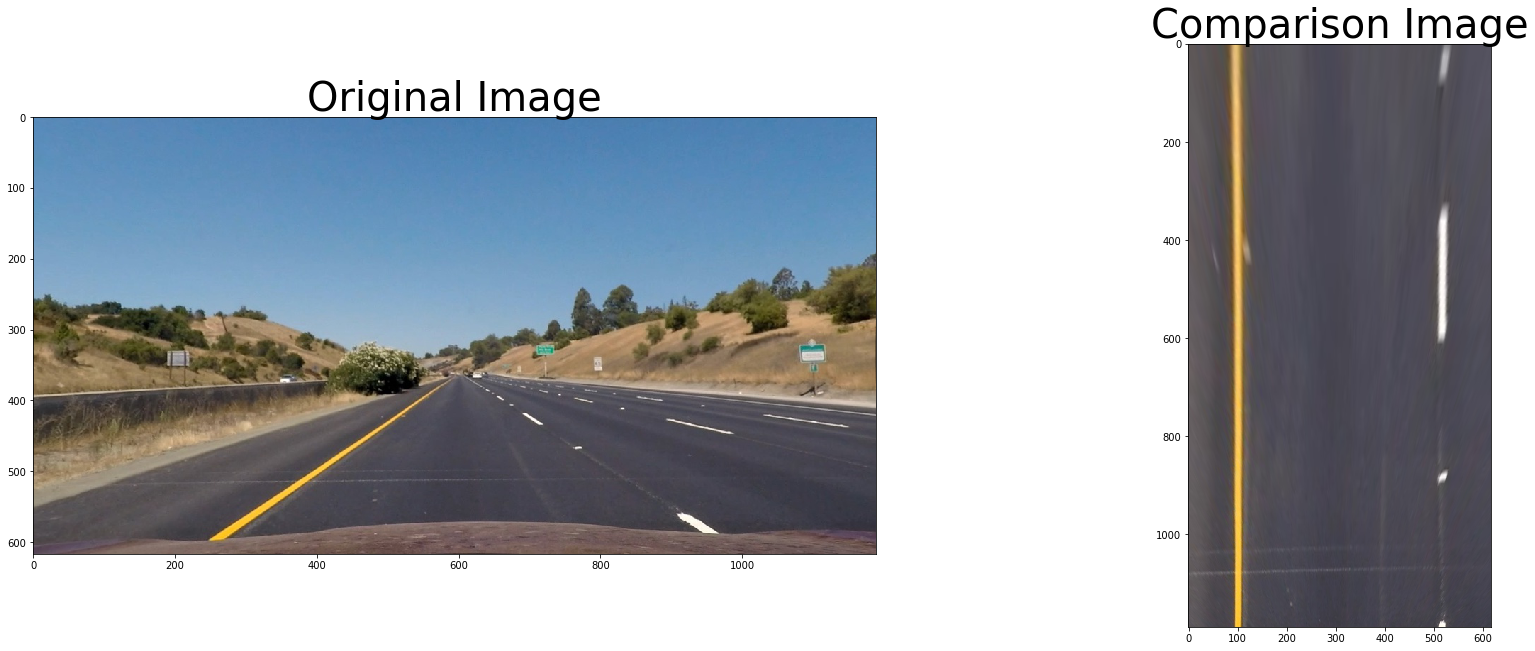

In [49]:
image = cv2.imread('undistorted_images\straight_lines1.jpg')
plot_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

warped, _ = warp_perspective(plot_image)
plot_side_by_side(plot_image,
                  warped)

In [11]:
def apply_colour_mask(image,
                      threshold_low,
                      threshold_high):
    binary_image = np.zeros_like(image[:,:,0])
    
    binary_image[(image[:, :, 0] >= threshold_low[0]) & (image[:, :, 0] <= threshold_high[0]) & \
                 (image[:, :, 1] >= threshold_low[1]) & (image[:, :, 1] <= threshold_high[1]) & \
                 (image[:, :, 2] >= threshold_low[2]) & (image[:, :, 2] <= threshold_high[2])] = 1
    
    return binary_image

In [12]:
def abs_sobel_thresh(img,
                     orient='x',
                     sobel_kernel=3,
                     thresh=(0, 255)):
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_output

def mag_thresh(image,
               sobel_kernel=3,
               mag_thresh=(0, 255)):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(image,
                  sobel_kernel=3,
                  thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [13]:
def detect_lines(image):
    """ Following approach taken in this tutorial 
        https://medium.com/towards-data-science/robust-lane-finding-using-advanced-computer-vision-techniques-mid-project-update-540387e95ed3
    """
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    yellow_hsv_low  = np.array([ 80, 80, 200])
    yellow_hsv_high = np.array([ 120, 255, 255])
    yellow_binary = apply_colour_mask(hsv_image,
                                      yellow_hsv_low,
                                      yellow_hsv_high)
    
    white_hsv_low  = np.array([  0,   0,   150])
    white_hsv_high = np.array([ 150,  80, 255])
    white_binary = apply_colour_mask(hsv_image,
                                     white_hsv_low,
                                     white_hsv_high)
    
    hls_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS).astype(np.float)
    sat_hls_low  = np.array([   0,    0, 100])
    sat_hls_high = np.array([ 255,  255, 255])
    sat_binary = apply_colour_mask(hls_image,
                                   sat_hls_low,
                                   sat_hls_high)
    
    colour_binary = np.zeros_like(white_binary)
    colour_binary[((yellow_binary == 1) | (white_binary == 1)) & (sat_binary == 1)] = 1
    
    # Convert to HLS color space and separate the V channel
    l_channel = hls_image[:,:,1]
    s_channel = hls_image[:,:,2]
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(s_channel, orient='x', sobel_kernel=3, thresh=(10, 150))
    grady = abs_sobel_thresh(s_channel, orient='y', sobel_kernel=3, thresh=(20, 75))
    mag_binary = mag_thresh(s_channel, sobel_kernel=ksize, mag_thresh=(50, 100))
    dir_binary = dir_threshold(s_channel, sobel_kernel=ksize, thresh=(0.75, 1.5))
    
    sobel_binary = np.zeros_like(colour_binary)
    sobel_binary[((gradx == 1) | (grady == 1)) & ((mag_binary == 1))] = 1

    combined = np.zeros_like(sobel_binary)
    combined[(sobel_binary == 1) | (colour_binary == 1)] = 1
    
    return combined

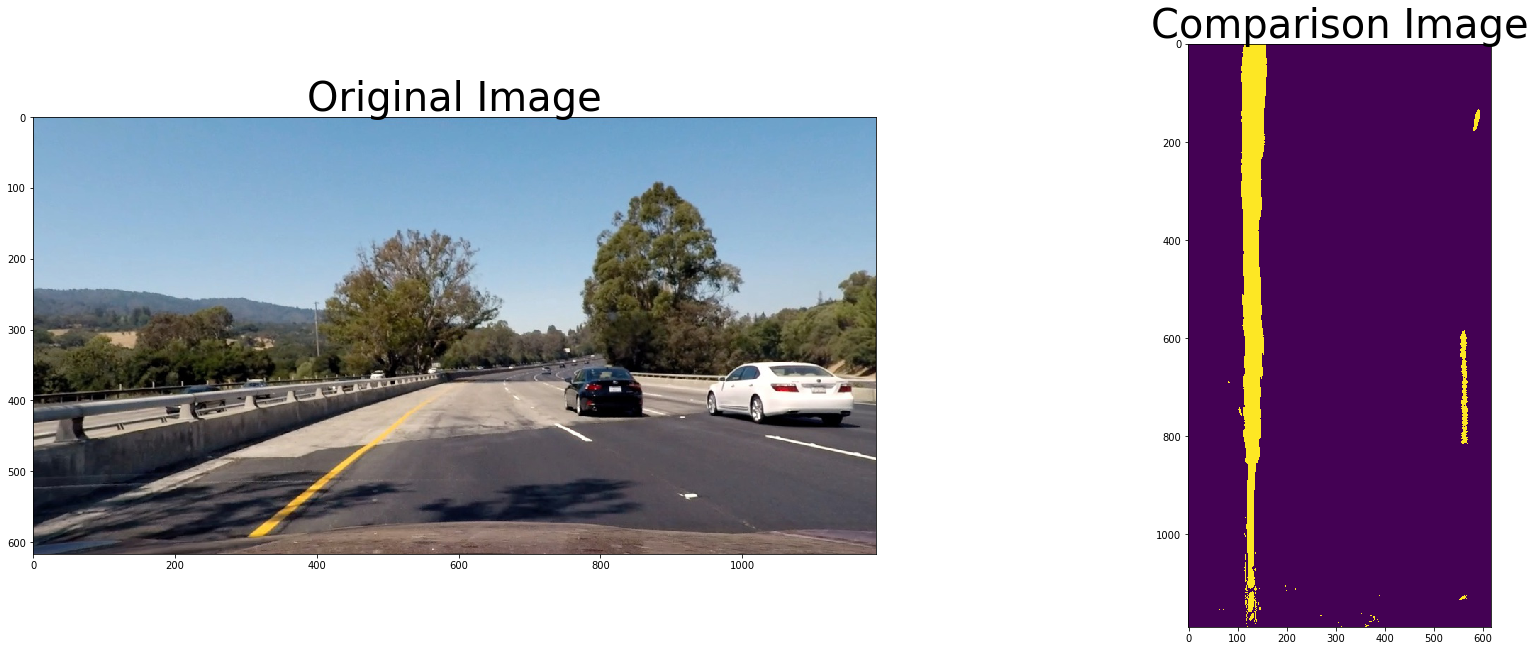

In [51]:
test_image_path = os.path.join(UNDISTORTED_DIR,
                               '*.jpg')
images = glob.glob(test_image_path)

image = cv2.imread(images[5])
plot_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

warped_image, _ = warp_perspective(plot_image)
binary_warped = detect_lines(warped_image)

plot_side_by_side(plot_image,
                  binary_warped)

In [15]:
def find_window_centroids(warped, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/10):,:int(warped.shape[1]/2)], axis=0)
    np.convolve(window,l_sum)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    l_coords = (l_center, warped.shape[0]/10)
    r_sum = np.sum(warped[int(3*warped.shape[0]/10):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    r_coords = (r_center, warped.shape[0]/10)
    
    # Add what we found for the first layer
    window_centroids.append((l_coords,r_coords))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        l_coords = (l_center, (level+0.5)*window_height)
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        r_coords = (r_center, (level+0.5)*window_height)
        # Add what we found for that layer
        window_centroids.append((l_coords,r_coords))

    return window_centroids

In [16]:
def fit_lines(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = (((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]).astype(np.int)
        good_right_inds = (((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]).astype(np.int)
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

#     window_width = 50 
#     window_height = 100 # Break image into 9 vertical layers since image height is 720
#     margin = 100 # How much to slide left and right for searching
#     window_centroids = find_window_centroids(binary_warped, window_width, window_height, margin)
#     positive_centroids = [centroid for centroid in window_centroids if all(element >= 0 for coord in centroid for element in coord)]
#     print(positive_centroids)
#     leftx = np.array([centroid[0][0] for centroid in positive_centroids])
#     lefty = np.array([centroid[0][1] for centroid in positive_centroids])
#     rightx = np.array([centroid[1][0] for centroid in positive_centroids])
#     righty = np.array([centroid[1][1] for centroid in positive_centroids])

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return left_fit, right_fit, left_fit_cr, right_fit_cr

In [17]:
left_fit, right_fit, left_fit_cr, right_fit_cr = fit_lines(binary_warped)

C:\Users\wat421\.conda\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [18]:
def calculate_curvature(left_fit_cr,
                        right_fit_cr,
                        binary_warped):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty) 
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

In [19]:
def visualise_lanes(plot_image,
                    binary_warped, 
                    left_fit,
                    right_fit,
                    left_fit_cr,
                    right_fit_cr,
                    Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (plot_image.shape[1], plot_image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(plot_image, 1, newwarp, 0.3, 0)
#     plt.imshow(result)
    
#     left_curverad, right_curverad = calculate_curvature(left_fit_cr,
#                                                         right_fit_cr,
#                                                         binary_warped)
#     avg_curverture = 0.5 * (left_curverad + right_curverad)
#     plt.text(10, 40, "curvature = {:0.2f} m".format(avg_curverture), color='white', weight='bold')
    
    return result

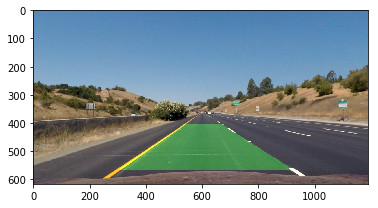

In [52]:
test_image_path = os.path.join(UNDISTORTED_DIR,
                               '*.jpg')
images = glob.glob(test_image_path)

image = cv2.imread(images[0])
plot_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

warped_image, Minv = warp_perspective(plot_image)
binary_warped = detect_lines(warped_image)
left_fit, right_fit, left_fit_cr, right_fit_cr = fit_lines(binary_warped)
result = visualise_lanes(plot_image,
                binary_warped, 
                left_fit,
                right_fit,
                left_fit_cr,
                right_fit_cr,
                Minv)

plt.imshow(result)

In [53]:
from moviepy.editor import VideoClip

cap = cv2.VideoCapture('project_video.mp4')

def make_frame(t):
    global cap
    if cap.isOpened():
        ret, frame = cap.read()

        plot_image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        warped_image, Minv = warp_perspective(plot_image)
        
        binary_warped = detect_lines(warped_image)
        left_fit, right_fit, left_fit_cr, right_fit_cr = fit_lines(binary_warped)
        
        detected_lanes = visualise_lanes(plot_image,
                                         binary_warped, 
                                         left_fit,
                                         right_fit,
                                         left_fit_cr,
                                         right_fit_cr,
                                         Minv)
        plt.imshow(dete)
        
        return detected_lanes

animation = VideoClip(make_frame, duration=2)
# export as a video file
animation.write_videofile("my_animation.mp4", fps=25)

cap.release()

[MoviePy] >>>> Building video my_animation.mp4
[MoviePy] Writing video my_animation.mp4


 98%|████████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:43<00:00,  1.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: my_animation.mp4 

